## Analysis of stock prices using PCA / Notebook 3

In this notebook we will study the dimensionality of stock price sequences, and show that they lie between the 1D of smooth functions and 2D of rapidly varying functions.

The mathematicians Manuel Mandelbrot and Richard Hudson wrote a book titled [The Misbehavior of Markets: A Fractal View of Financial Turbulence](https://www.amazon.com/gp/product/0465043577?ie=UTF8&tag=trivisonno-20&linkCode=as2&camp=1789&creative=9325&creativeASIN=0465043577).  In this book they demonstrate that financial sequences have a fractal dimension that is higher than one. In other words, the changes in stock prices are more similar to random walk, than to a smooth differentiable curve.

In this notebook we will estimate the fractal dimension of sequences corresponding to the log of the price of a stock. We will do the same for some other, non-random sequences.

We will use the [Box Counting](https://en.wikipedia.org/wiki/Box_counting) method to estimate the dimension.

### Box Counting
For the sake of simplicity, lets start with a simple smooth curve corresoinding to $sin(x)$.
Intuitively speaking, the dimension of this curve should be 1. Lets see how we measure that using box-counting.

The idea is simple: we split the 2D plane into smaller and smaller rectangles and count the number of rectangles that touch the curve.  The gridlines in the figure below partition the figure into $16 \times 16 = 256$ rectangles. The yellow shading corresponds the partition of the figure into $8 \times 8$ rectangles. The green corresponds to the partition into $16\times 16$ (which is the same as the grid), The blue and the red correspond to partitions into $32\times32$ and $64 \times 64$ respectively. You can see that as theboxes get smaller their number increases. 

![Sinusoid](figs/Sinusoid.BoxCount.png)

The dimension is defined by the relation between the size of the cubes and the number of rectangle that touch the curve. More precisly, we say that the size of a rectangle in a $n \times n$ partition is $\epsilon=1/n$. We denote by $N(\epsilon)$ the number of rectangles of size $\epsilon$ that touch the curve. Then if $d$ is the dimension, the relationship between $N(\epsilon)$ and $\epsilon$ is 
$$
N(\epsilon) = \frac{C}{\epsilon^d}
$$
For some constant $C$

Taking $\log$s of both side we get 
$$
(1)\;\;\;\;\;\;\;\;\;\;\;\;\log N(\epsilon) = \log C + d \log \frac{1}{\epsilon}
$$

We can use this equation to estimate $d$ as follows: let $\epsilon_2 \gg \epsilon_1$ be two sizes that are far apart (say $\epsilon_1=1/4$ and $\epsilon_2=1/1024$), and let $N(\epsilon_1),N(\epsilon_2)$ be the corresponding box counts. Then by taking the difference between Equation (1) for the two sizes we get the estimate
$$
    d \approx \frac{\log N(\epsilon_1) - \log N(\epsilon_2)}{\log \epsilon_2- \log \epsilon_1}
$$

Note that this is an estimate, it depends on the particular values of $\epsilon_1$ and $\epsilon_2$. We can refer to it as the "dimension" if we get the same number for any choice of the two sizes (as well as other details sich as the extent of the function.

Here are similar figures for the seque 
![AMZN](figs/AMZN.BoxCount.png)

![IBM](figs/IBM.BoxCount.png)		

### Download the data files
You might have made a mistake in producing the file `data/SP500.csv`. To avoid propagating this mistake, we download the correct file from S3

In [4]:
!wget https://mas-dse-open.s3.amazonaws.com/Stocks/data.tgz
!tar xzvf data.tgz

--2018-06-09 00:03:31--  https://mas-dse-open.s3.amazonaws.com/Stocks/data.tgz
Resolving mas-dse-open.s3.amazonaws.com (mas-dse-open.s3.amazonaws.com)... 52.218.248.82
Connecting to mas-dse-open.s3.amazonaws.com (mas-dse-open.s3.amazonaws.com)|52.218.248.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28559983 (27M) [application/x-tar]
Saving to: ‘data.tgz.1’

data.tgz.1          100%[===================>]  27.24M  11.4MB/s    in 2.4s    

2018-06-09 00:03:33 (11.4 MB/s) - ‘data.tgz.1’ saved [28559983/28559983]

data/
data/PCA.pickle
data/SP500.csv
data/tickerInfo.tsv


In [5]:
#import findspark
#findspark.init()
from pyspark import SparkContext

#sc.stop()
sc = SparkContext(master="local[3]")

from pyspark.sql import *
sqlContext = SQLContext(sc)

%pylab inline

import numpy as np


ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[3]) created by __init__ at <ipython-input-1-515852f2d61a>:6 

In [6]:
df=sqlContext.read.csv('data/SP500.csv',header='true',inferSchema='true')
df.count()

13422

In [9]:
columns=df.columns
columns

['Date',
 'train/AAPL_D',
 'train/ABC_D',
 'train/ABT_D',
 'train/ACN_D',
 'train/ADBE_D',
 'train/ADI_D',
 'train/ADM_D',
 'train/ADP_D',
 'train/ADSK_D',
 'train/AEE_D',
 'train/AEP_D',
 'train/AES_D',
 'train/AET_D',
 'train/AFL_D',
 'train/AGN_D',
 'train/AIG_D',
 'train/AIV_D',
 'train/AIZ_D',
 'train/AKAM_D',
 'train/ALL_D',
 'train/ALXN_D',
 'train/AMAT_D',
 'train/AMD_D',
 'train/AMGN_D',
 'train/AMP_D',
 'train/AMT_D',
 'train/AMZN_D',
 'train/AN_D',
 'train/AON_D',
 'train/APA_D',
 'train/APC_D',
 'train/APD_D',
 'train/APH_D',
 'train/AVB_D',
 'train/AVY_D',
 'train/AXP_D',
 'train/AZO_D',
 'train/A_D',
 'train/BAC_D',
 'train/BAX_D',
 'train/BA_D',
 'train/BBBY_D',
 'train/BBT_D',
 'train/BBY_D',
 'train/BCR_D',
 'train/BDX_D',
 'train/BEN_D',
 'train/BHI_D',
 'train/BIIB_D',
 'train/BK_D',
 'train/BLK_D',
 'train/BLL_D',
 'train/BMY_D',
 'train/BSX_D',
 'train/BWA_D',
 'train/BXP_D',
 'train/CAG_D',
 'train/CAH_D',
 'train/CAT_D',
 'train/CA_D',
 'train/CBG_D',
 'train/CBS

In [7]:
col=[c for c in columns if '_P' in c]
tickers=[a[:-2] for a in col]
tickers[:10],len(tickers)

([], 0)

In [4]:
def get_seq(ticker):
    key=ticker+"_P"
    L=df.select(key).collect()
    L=[x[key] for x in L if not x[key] is None]
    return L

In [6]:
def calc_splitpoints(R,count):
    return arange(R[0],R[1],(R[1]-R[0])/(count*1.00001))
def Box_count(LL,ticker):
    X_range=[0,len(LL)]
    Y_range=[min(LL),max(LL)]
    Y_range,X_range

    max_exp=12
    N=np.zeros([max_exp,2])
    covers={}
    for E in range(max_exp):
        count=2**E
        X=[int(x) for x in calc_splitpoints(X_range,count)]
        Ystep=(Y_range[1]-Y_range[0])/count

        T=np.zeros(count)
        blocks=[]
        for i in range(count):
            xmin,xmax=X[i:i+2]
            S=LL[xmin:xmax]
            _ymin=floor(min(S)/Ystep)
            ymin=_ymin*Ystep
            _ymax=ceil(max(S)/Ystep)
            ymax=_ymax*Ystep
            T[i]=_ymax-_ymin
            blocks.append((xmin,xmax,ymin,ymax))
        covers[E] = blocks
        N[E,:]=[count,sum(T)]
    dim=(log(N[-1,1])-log(N[4,1]))/(log(N[-1,0])-log(N[4,0]))
    print('dim=',dim)
    plot(log(N[:,0]),log(N[:,1]));
    title('Box Count Graph for '+ticker)
    xlabel('log 1/epsilon')
    ylabel('log N');
    grid()
    return N,dim,covers

In [7]:
def analyze_sequence(L,ticker):
    figure(figsize=(13,5))
    subplot(121)
    LL=log(L)
    plot(LL)
    title('time series for '+ticker)
    xlabel('days')
    ylabel('log price')
    grid()
    subplot(122)
    N,dim,covers=Box_count(LL,ticker)
    return N,dim,covers

In [8]:
def analyze_stock(ticker):
    L=get_seq(ticker)
    N,dim,covers=analyze_sequence(L,ticker)
    return N,dim,covers,L

dim= 1.3400632458632322


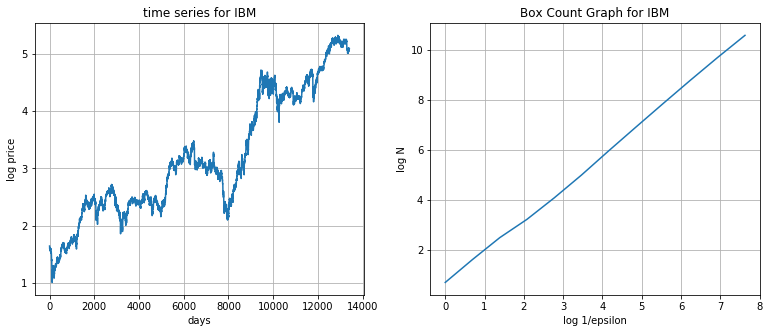

In [10]:
ticker='IBM'
N,dim,covers,L=analyze_stock(ticker)

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
G=16
def plot_boxes(LL,covers):
    figure(figsize=[15,10])
    plot(LL)
    axes=gca()
    xmin=0.0; xmax=len(LL)-1.0
    ymin=min(LL)
    ymax=max(LL)
    yloc = plticker.MultipleLocator((ymax-ymin)/G)
    xloc = plticker.MultipleLocator((xmax-xmin)/G)
    axes.xaxis.set_major_locator(xloc)
    axes.yaxis.set_major_locator(yloc)

    # Add the grid
    axes.grid(which='major', axis='both', linestyle='-')
    
    colors='gbrygbrygbrygbry'
    for level in range(3,8):
        blocks=covers[level]

        for xmin,xmax,ymin,ymax in blocks:
            width=xmax-xmin
            height=ymax-ymin 
            axes.add_patch(
                patches.Rectangle(
                    (xmin, ymin),   # (x,y)
                    width,          # width
                    height,          # height
                    alpha=0.2,color=colors[level]
                ))

dim= 1.2341597529668658


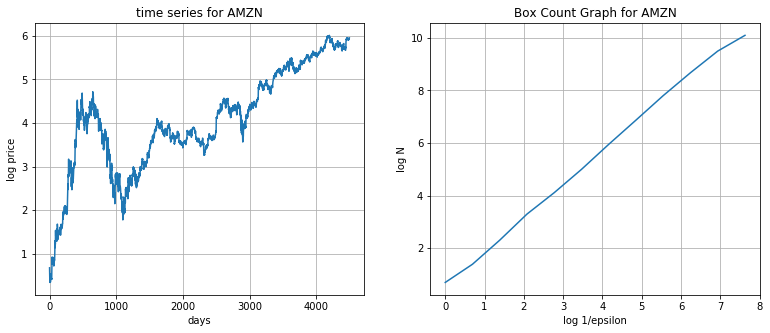

In [13]:
ticker='AMZN'
N,dim,covers,L=analyze_stock(ticker)

Text(0.5,1,'box plot for AMZN')

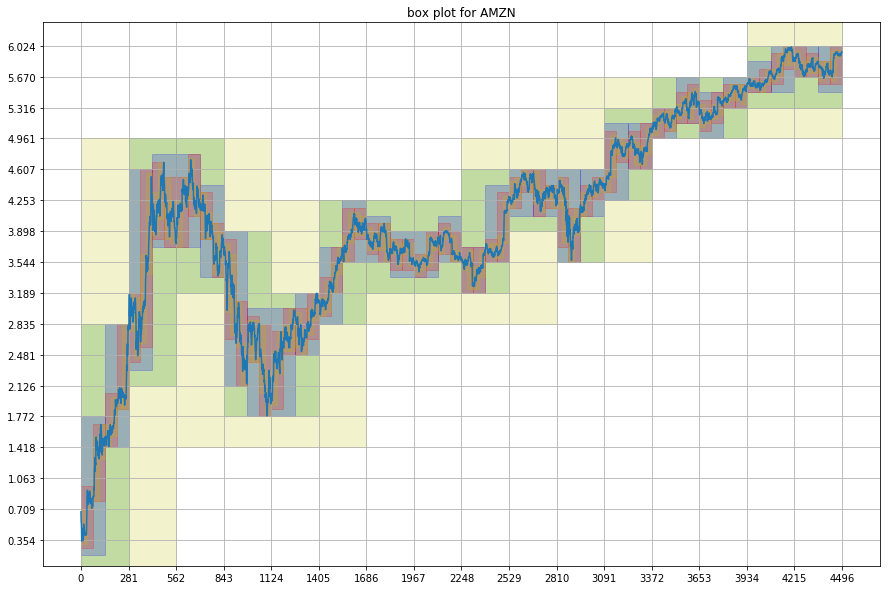

In [14]:
LL=log(L)
plot_boxes(LL,covers)
title('box plot for '+ticker)



In [15]:
x=arange(-1,1,0.0001)
y=exp(sin(8*x))

dim= 0.9906188401796695


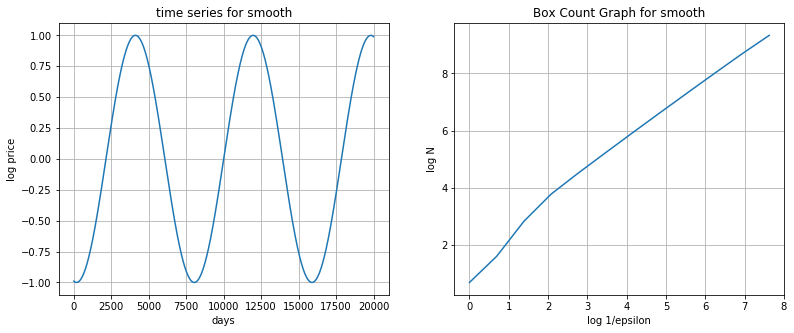

In [16]:
N,dim,covers=analyze_sequence(y,'smooth')

Text(0.5,1,'box plot for smooth')

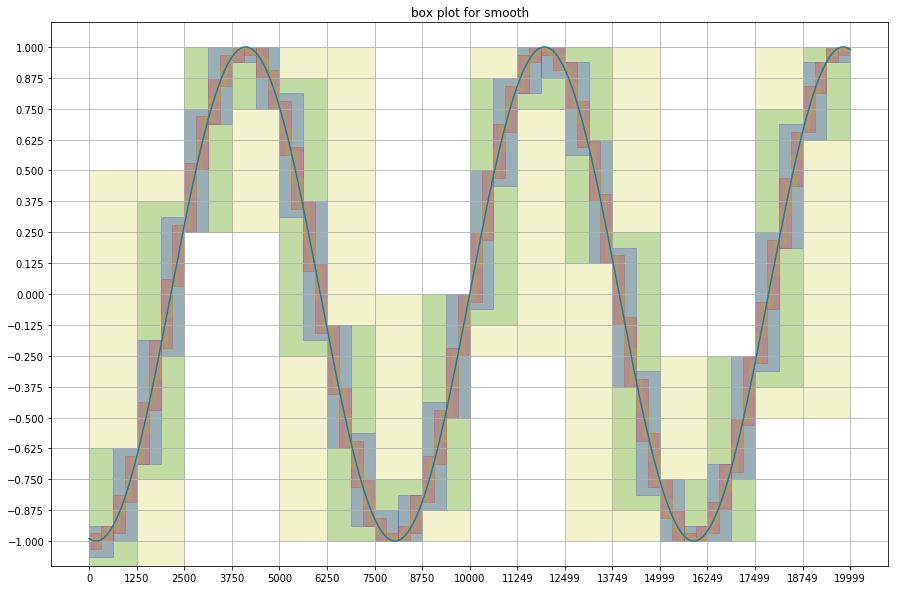

In [17]:
LL=log(y)
plot_boxes(LL,covers)
title('box plot for '+'smooth')

dim= 2.0


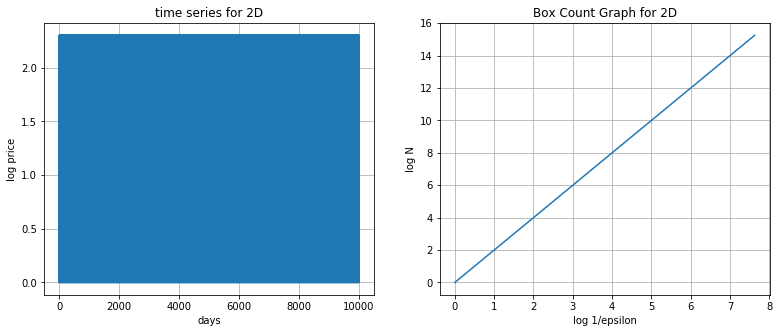

In [18]:
L=np.array([1.,10.]*5000)
X=analyze_sequence(L,'2D')

dim= 1.2735918966833633


(array([[1.000e+00, 2.000e+00],
        [2.000e+00, 6.000e+00],
        [4.000e+00, 1.300e+01],
        [8.000e+00, 2.800e+01],
        [1.600e+01, 6.900e+01],
        [3.200e+01, 1.560e+02],
        [6.400e+01, 3.770e+02],
        [1.280e+02, 9.460e+02],
        [2.560e+02, 2.470e+03],
        [5.120e+02, 6.208e+03],
        [1.024e+03, 1.522e+04],
        [2.048e+03, 3.331e+04]]),
 1.2735918966833633,
 {0: [(0, 7703, 0.0, 9.609492772895251)],
  1: [(0, 3851, 0.0, 7.2071195796714385),
   (3851, 7703, 0.0, 7.2071195796714385)],
  2: [(0, 1925, 1.2011865966119064, 4.804746386447626),
   (1925, 3851, 2.402373193223813, 6.005932983059532),
   (3851, 5777, 4.804746386447626, 7.2071195796714385),
   (5777, 7703, 1.2011865966119064, 7.2071195796714385)],
  3: [(0, 962, 1.8017798949178596, 3.6035597898357192),
   (962, 1925, 2.402373193223813, 4.204153088141672),
   (1925, 2888, 3.002966491529766, 4.804746386447626),
   (2888, 3851, 4.204153088141672, 6.005932983059532),
   (3851, 4814, 5.405

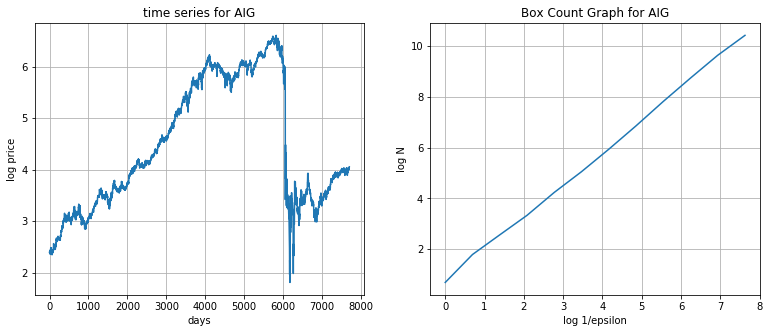

In [19]:
analyze_stock('AIG')